# Plots of GLODAP

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from netcdf_climate_analysis_funcs import climdata, multiplot
from netcdf_climate_analysis_funcs.small_funcs import xy_region

/noc/users/acable/miniforge3/envs/AISIT/lib/python3.13/site-packages/symfit/core/printing.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## 0. Loading the GLODAP data

In [2]:
# Name of columns
latitude_field = "Latitude [degrees North]"
longitude_field = "Longitude [degrees East]"
salinity_field = "SALNTY [PSS-78]"
oxygen_iso_field = "O18/O16 [/MILLE]"
reference_field = "Sample ID:INTEGER"
dt_format = "yyyy-mm-ddThh:mm:ss.sss"
temperature_field = "TEMPERATURE [DEG C]"

In [64]:
# --- Load CSV ---
df = pd.read_csv("input_data/window_data_from_GLODAPv2.2023.csv")

# --- Clean data ---
# Replace missing or placeholder values (like '**') with NaN
df = df.replace("**", np.nan)
df = df.dropna(subset=[longitude_field, latitude_field, salinity_field, oxygen_iso_field,temperature_field])


In [65]:
# Convert columns to numeric if necessary
df[longitude_field] = pd.to_numeric(df[longitude_field])
df[latitude_field] = pd.to_numeric(df[latitude_field])
df[salinity_field] = pd.to_numeric(df[salinity_field])
df[oxygen_iso_field] = pd.to_numeric(df[oxygen_iso_field])

df["datetime"] = pd.to_datetime(df[dt_format])

## 1. Lat-lon plots

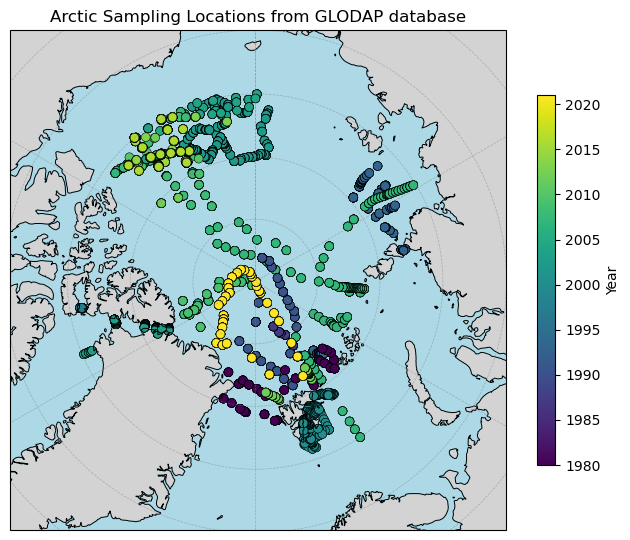

In [ ]:
# --- Set up the projection ---
proj = ccrs.NorthPolarStereo()

# --- Create figure ---
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=proj)

# Add base features
ax.add_feature(cfeature.LAND, color="lightgray")
ax.add_feature(cfeature.OCEAN, color="lightblue")
ax.add_feature(cfeature.COASTLINE, linewidth=0.7)
ax.gridlines(draw_labels=False, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")

# Set extent (limit to Arctic)
ax.set_extent([-180, 180, 70, 90], ccrs.PlateCarree())

# --- Plot the sample locations ---
sc = ax.scatter(
    df[longitude_field],
    df[latitude_field],
    c=df["datetime"].dt.year,
    s=40,
    cmap="viridis",
    transform=ccrs.PlateCarree(),
    edgecolor="black",
    linewidth=0.4,
)

# --- Colorbar ---
cb = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.6, pad=0.05)
cb.set_label("Year")

# --- Title ---
plt.title("Arctic Sampling Locations from GLODAP database", fontsize=12)

## 2. Temperature, Salinity & d18O plots

In [7]:
# --- 2️⃣ Scatter plot: d18O vs. Salinity ---
fig_scatter = px.scatter(
    df,
    x=salinity_field,
    y=oxygen_iso_field,
    color=df["datetime"].dt.year,
    hover_data=[ latitude_field,longitude_field, reference_field],
    title="δ¹⁸O vs. Salinity from GLODAP database",
    # trendline="ols"  # optional: adds regression line
)
fig_scatter.update_layout(xaxis_title="Salinity", yaxis_title="δ¹⁸O (‰)")
# fig_scatter.show()


In [9]:
# --- 2️⃣ Scatter plot: d18O vs. Salinity ---
fig_scatter = px.scatter(
    df,
    x=temperature_field,
    y=oxygen_iso_field,
    color=df["datetime"].dt.year,
    hover_data=[ latitude_field,longitude_field, reference_field],
    title="δ¹⁸O vs. Temperature from GLODAP database",
    # trendline="ols"  # optional: adds regression line
)
fig_scatter.update_layout(xaxis_title="Temperature ($^o$C)", yaxis_title="δ¹⁸O (‰)")
# fig_scatter.show()

In [8]:

# --- 2️⃣ Scatter plot: Temperature vs. Salinity ---
fig_scatter2 = px.scatter(
    df,
    x=salinity_field,
    y=temperature_field,
    color=df["datetime"].dt.year,
    hover_data=[ latitude_field,longitude_field, reference_field],
    title="Temperature vs. Salinity from GLODAP database",
    # trendline="ols"  # optional: adds regression line
)
fig_scatter2.update_layout(xaxis_title="Salinity", yaxis_title="Temperature")
# fig_scatter2.show()

## 3. Timeseries plots

GLODAP data isn't spread equally across all months of the year. As can be seen below, most data is from August & September. November-April & June aren't represented at all.

In [68]:
# Count the number of observations in each month of a year
df_nosumm["datetime"].dt.month.value_counts().sort_index()

datetime
8     3215
9     2423
10     795
Name: count, dtype: int64

In [52]:
# Extract day-year labels for x-axis
df['day_label'] = pd.to_datetime(df['datetime'].dt.strftime('%Y-%m-%d'))
df_daily = df.groupby('day_label').mean([temperature_field,salinity_field,oxygen_iso_field]).reset_index()
df_daily["date"] = pd.to_datetime(df["day_label"])
df_daily= df_daily.sort_values("date")

In [6]:
# Extract month-year labels for x-axis
df['month_label'] = df['datetime'].dt.strftime('%Y-%m')
df_monthly = df.groupby('month_label').mean([temperature_field,salinity_field,oxygen_iso_field]).reset_index()

In [71]:
df_nosumm = df[~df['datetime'].dt.month.isin([5, 7])] # Drop summer months
df['year_label'] = df['datetime'].dt.strftime('%Y')
df_yearly = df.groupby('year_label').mean([temperature_field,salinity_field,oxygen_iso_field]).reset_index()



In [72]:
df_yearly

,year_label,SALNTY [PSS-78],O18/O16 [/MILLE],TEMPERATURE [DEG C],Station,Sample ID:INTEGER,Longitude [degrees East],Latitude [degrees North],DEPTH [M]
0,1980,34.086764,-0.271092,-0.143431,7298.747440,11.228669,155.754145,81.001846,258.901024
1,1987,34.572179,0.038940,-0.423839,43.132450,14.059603,29.369689,83.676457,607.715232
2,1991,34.250714,-0.364495,-0.396314,6967.282230,10.724739,83.015472,85.938955,579.317083
3,1993,34.423615,-0.029882,-0.034882,83.349705,12.880157,89.485254,79.740501,709.130136
4,1997,33.350809,-1.140191,-0.720183,1835.732824,9.068702,282.329744,77.158710,219.732824
5,2000,34.165964,0.003880,1.090442,4907.283613,2.357143,22.345361,77.767500,61.378151
6,2002,32.930100,-1.103395,-0.859271,3725.935118,9.771370,192.685726,77.778771,241.851596
7,2003,32.885995,-1.296546,-0.637687,2763.359694,7.125000,274.210224,79.568645,148.076531
8,2004,32.338315,-1.261132,-0.908647,7360.158088,8.830882,204.674490,76.578735,224.090073
9,2005,31.772959,-1.572463,-0.940843,3919.693878,4.857143,241.195839,78.922653,133.469388


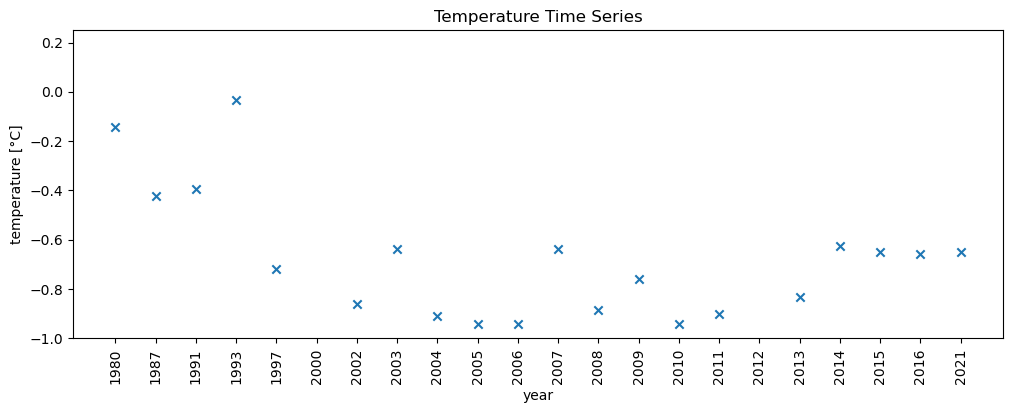

In [76]:
tlabel, dfplot = "year", df_yearly
# Plot with categorical x-axis
plt.figure(figsize=(12,4))
plt.scatter(dfplot[f'{tlabel}_label'], dfplot[temperature_field], marker='x')
plt.xlabel(tlabel)
plt.ylabel('temperature [°C]')
plt.ylim([-1,0.25])

if tlabel == "day":
    months = dfplot['date'].dt.month.unique()
    tick_positions = [dfplot[dfplot['date'].dt.month == m].index[0] for m in months]
    plt.xticks(tick_positions, months, rotation=90)
else:
    plt.xticks(rotation=90)


plt.title('Temperature Time Series')
#plt.grid(True)
plt.show()